# Выбор локации для скважины

_____
**Описание исследования.**

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. А также необходимо проанализировать возможную прибыль и риски техникой *Bootstrap.*

_____
**Условия задачи.**

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

_____
**Исходные данные.**

Данные геологоразведки трёх регионов находятся в файлах: geo_data_0.csv,  geo_data_1.csv,  geo_data_2.csv.

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).
_____
**Данное исследование разделим на несколько частей.**
1. [Загрузка и подготовка данных](#chapter1)
2. [Обучение и проверка модели](#chapter2)
3. [Подготовка к расчёту прибыли](#chapter3)
4. [Расчёт прибыли и рисков](#chapter4)
5. [Итоговый вывод](#chapter5)
6. [Чек-лист готовности проекта](#chapter6)

In [1]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection, metrics
from sklearn.metrics import mean_squared_error, make_scorer
import phik
from phik.report import plot_correlation_matrix
import os
from pathlib import Path
from numpy.random import RandomState

# параметры обучения
TEST_SIZE = 0.25
RANDOM_STATE = 42

## Загрузка и подготовка данных 
<a class="anchor" id="chapter1"></a>

In [3]:
def loading_info(pth):
    """
    Функция загрузки датасетов и 
    """
    if os.path.exists(pth):
        #загрузка данных из файла
        data = pd.read_csv(pth)
        # отобразим загруженные датасеты
        display(data.head())
        # отобразим основную информацию о загруженном датасете
        display(data.info())
        display(data.describe())
        return data
    else:
        print(f"Не верный путь к файлу: {pth}")

In [4]:
# пути к файлам с датасетами
pth1 = '/datasets/geo_data_0.csv'
pth2 = '/datasets/geo_data_1.csv'
pth3 = '/datasets/geo_data_2.csv'

list_pth = [pth1, pth2, pth3]


for i in list_pth:
    variable_name = Path(i).stem
    print('Имя переменной датасета: ', variable_name)
    globals()[variable_name] = loading_info(i)

Имя переменной датасета:  geo_data_0


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Имя переменной датасета:  geo_data_1


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Имя переменной датасета:  geo_data_2


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [5]:
# словарь с названием датасета и самим датасетом соответственно
datasets = {
    "geo_data_0": geo_data_0,
    "geo_data_1": geo_data_1,
    "geo_data_2": geo_data_2
}
# цикл для поиска дубликатов в датасете
for name, data in datasets.items():
    print(f'Явные дубликаты датасета {name}:', data.duplicated().sum())

Явные дубликаты датасета geo_data_0: 0
Явные дубликаты датасета geo_data_1: 0
Явные дубликаты датасета geo_data_2: 0


In [6]:
def hist_with_boxplot(dаta, col):
    """
    Функция построения графиков
    data - обрабатываемый датасет
    col - признаки, для которых строятся графики
    """
    f, ax = plt.subplots(1, 2, figsize=(22, 4))
    ax[0].set_title(f'Гистограмма для {col}', fontsize=16)
    ax[0].set_ylabel('Количество', fontsize=14)
    sns.histplot(dаta, bins=20, kde=True, ax=ax[0], x=col, palette='pastel')
    ax[1].set_title(f'График ящик с усами для {col}', fontsize=16)
    sns.boxplot(data=dаta, ax=ax[1], y=col, palette='pastel')
    ax[1].set_ylabel(col, fontsize=14)
    plt.show()
    
def scatter(data, x, y):
    # Построение графика
    sns.scatterplot(x=data[x], y=data[y])

    # Добавление заголовка и меток осей
    plt.title(f'Диаграмма рассеяния {x} и {y}')
    plt.xlabel(f'{x}')
    plt.ylabel(f'{y}')

    # Показать график
    plt.show()

In [7]:
num = ['f0', 'f1', 'f2', 'product']

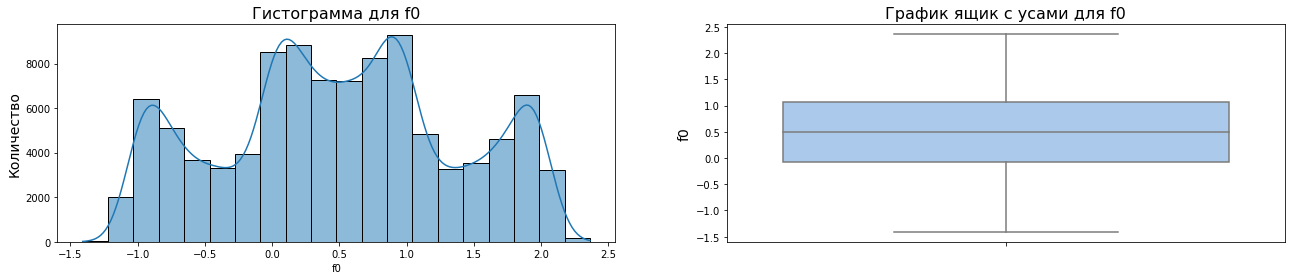

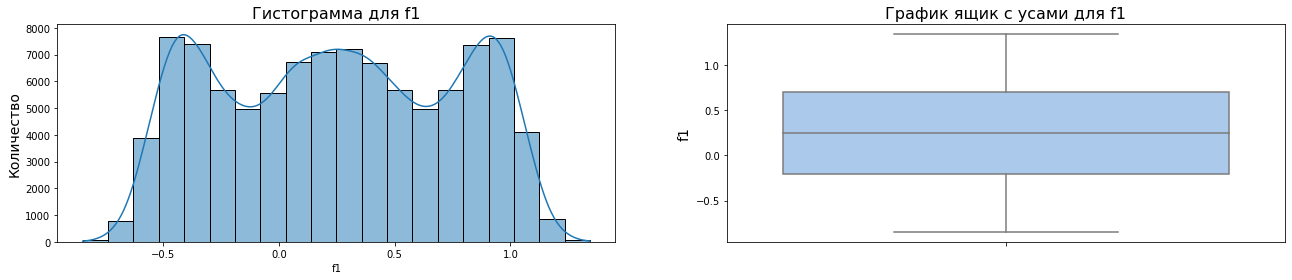

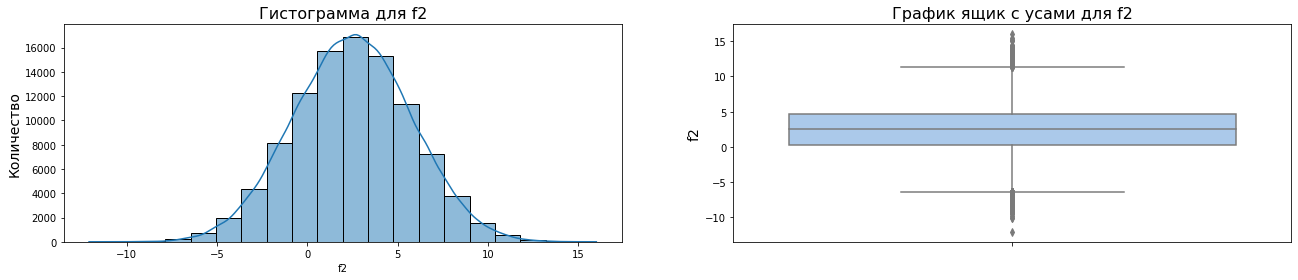

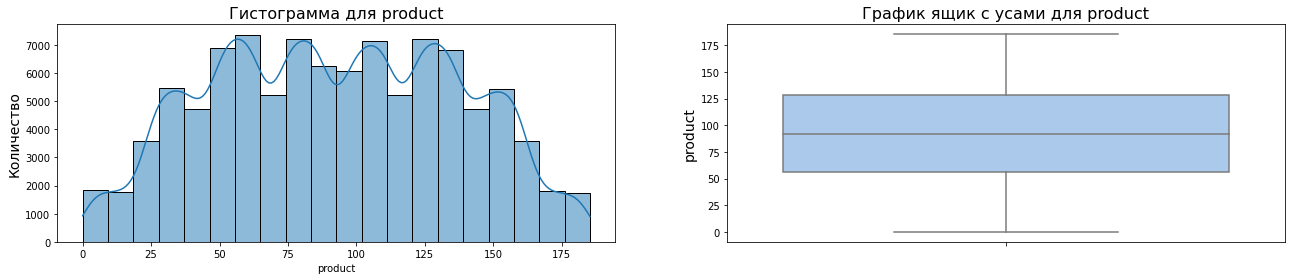

In [8]:
for i in num:
    hist_with_boxplot(geo_data_0, i)

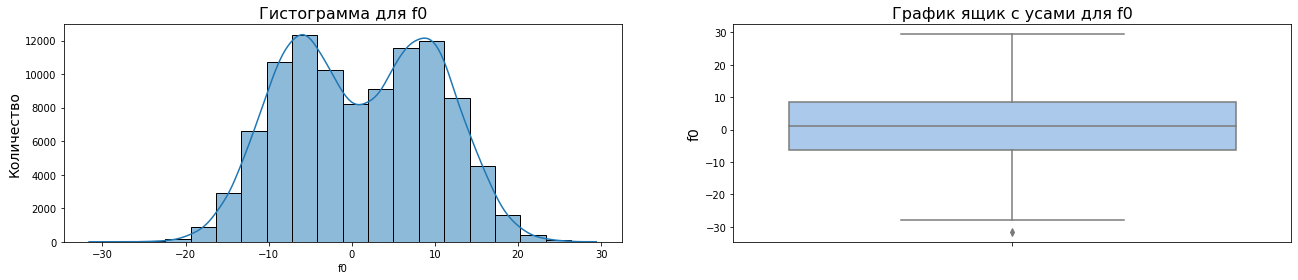

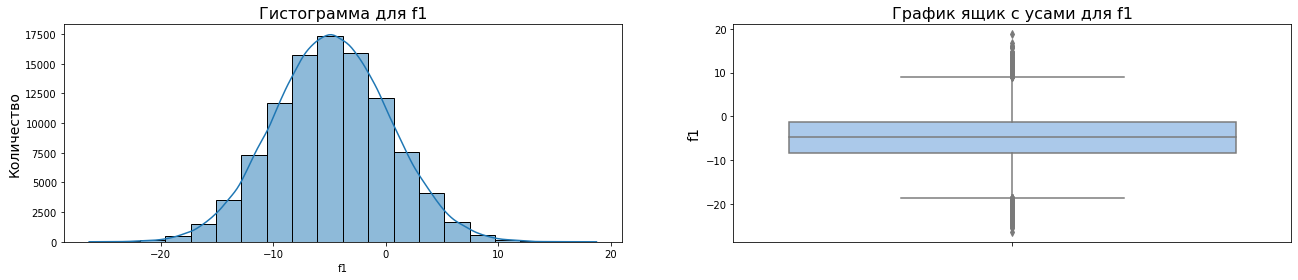

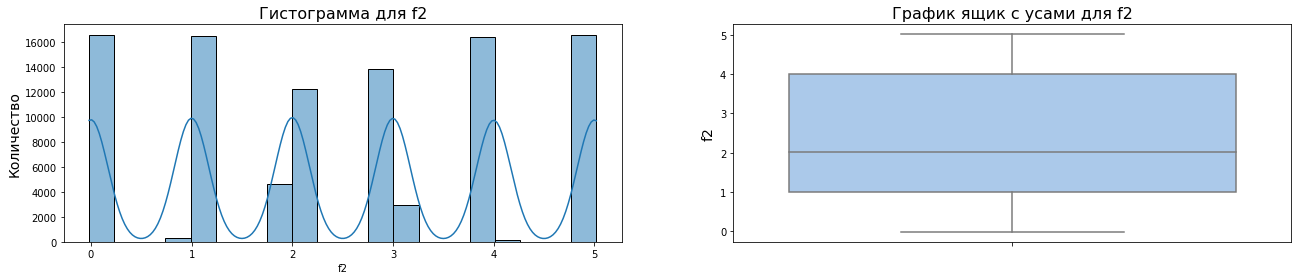

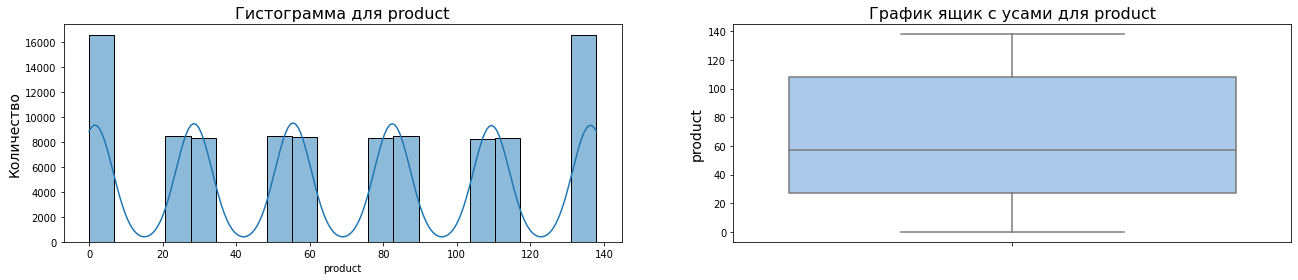

In [9]:
for i in num:
    hist_with_boxplot(geo_data_1, i)

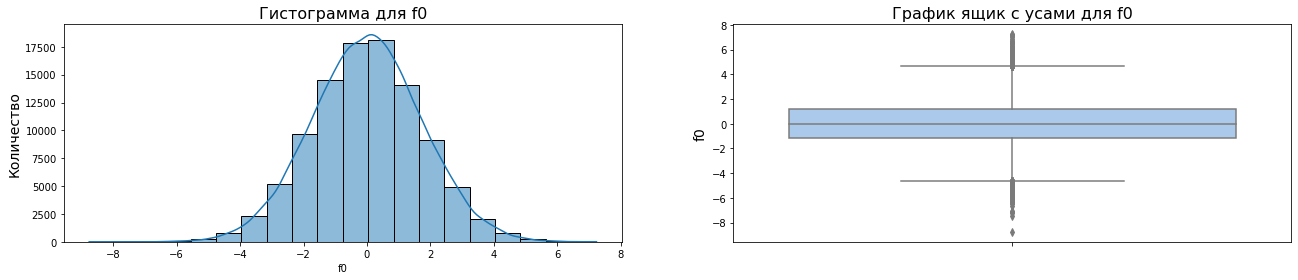

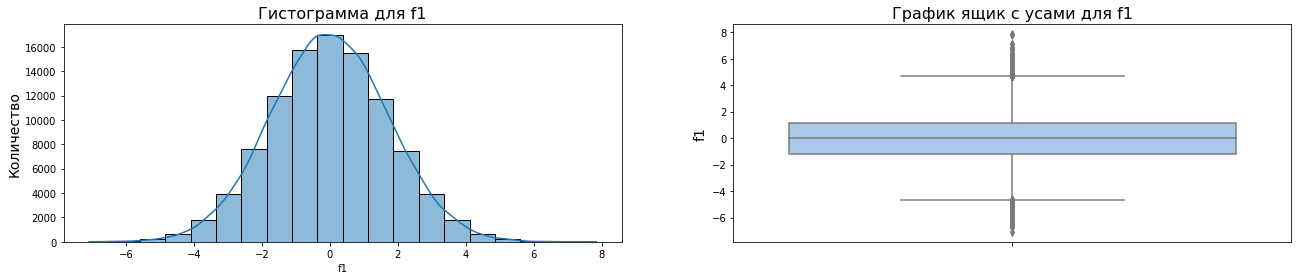

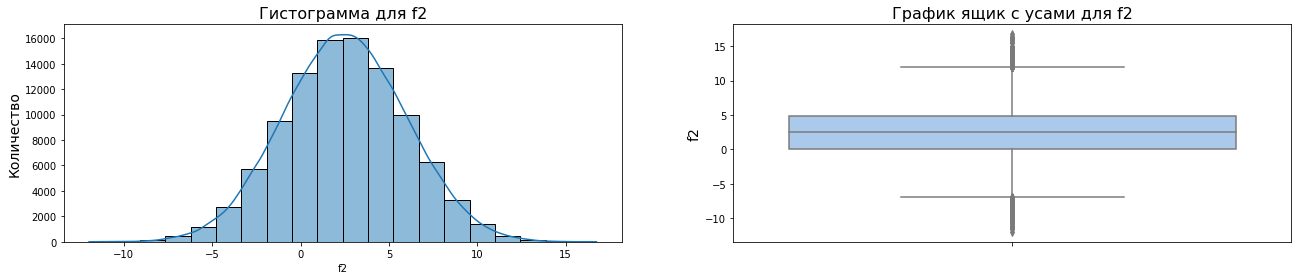

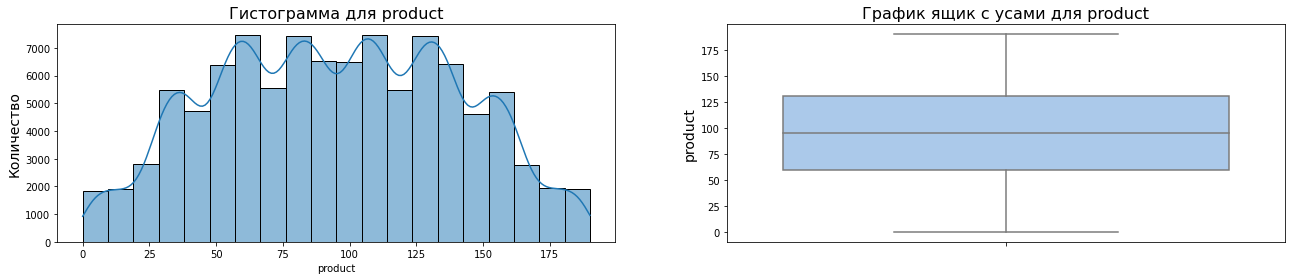

In [10]:
for i in num:
    hist_with_boxplot(geo_data_2, i)

In [11]:
target = 'product'
num = ['f0', 'f1', 'f2']

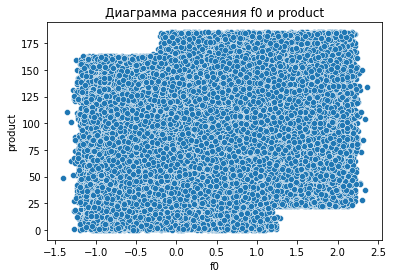

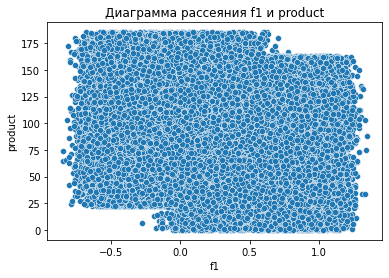

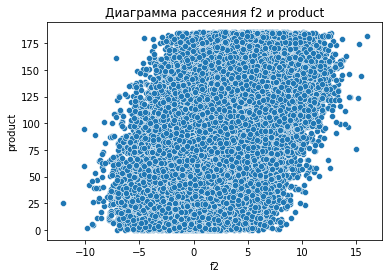

In [12]:
for i in num:
    scatter(geo_data_0, i, target)

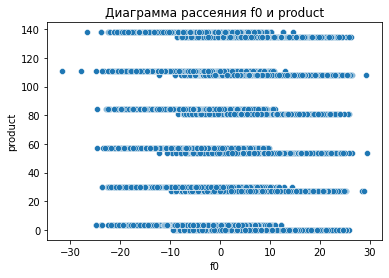

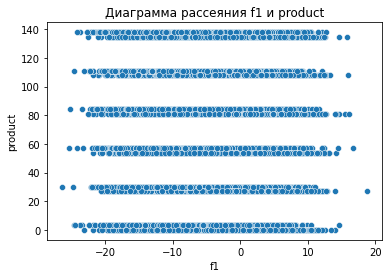

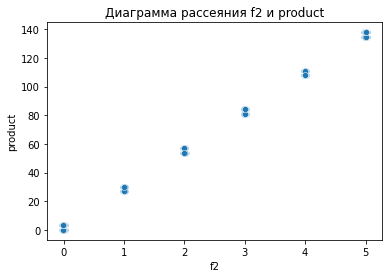

In [13]:
for i in num:
    scatter(geo_data_1, i, target)

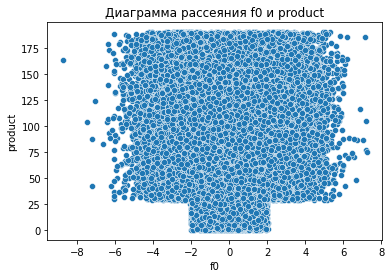

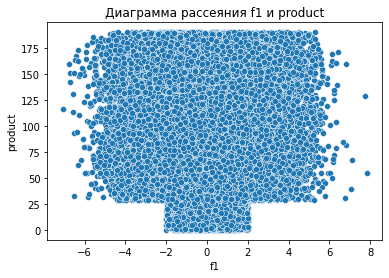

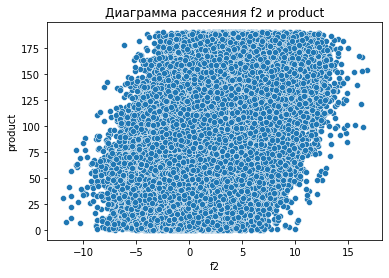

In [14]:
for i in num:
    scatter(geo_data_2, i, target)

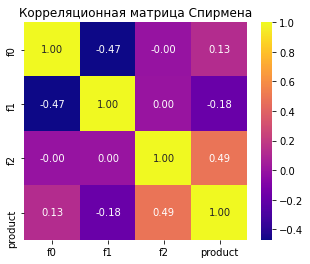

In [15]:
geo_data_0_without_id = geo_data_0.drop(columns=['id'])
fig, ax = plt.subplots(figsize=(5, 4))  # Размер фигуры можно настроить
sns.heatmap(geo_data_0_without_id.corr(method='spearman'), annot=True, fmt='.2f', cmap='plasma')
plt.title('Корреляционная матрица Спирмена')
plt.show()

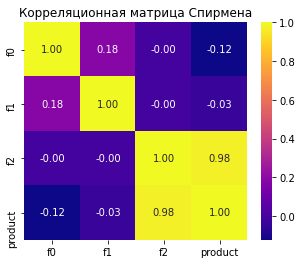

In [16]:
geo_data_1_without_id = geo_data_1.drop(columns=['id'])
fig, ax = plt.subplots(figsize=(5, 4))  # Размер фигуры можно настроить
sns.heatmap(geo_data_1_without_id.corr(method='spearman'), annot=True, fmt='.2f', cmap='plasma')
plt.title('Корреляционная матрица Спирмена')
plt.show()

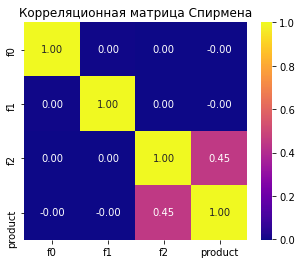

In [17]:
geo_data_2_without_id = geo_data_2.drop(columns=['id'])
fig, ax = plt.subplots(figsize=(5, 4))  # Размер фигуры можно настроить
sns.heatmap(geo_data_2_without_id.corr(method='spearman'), annot=True, fmt='.2f', cmap='plasma')
plt.title('Корреляционная матрица Спирмена')
plt.show()

**Вывод** 
- отсутствуют пропуски;
- типы данных корректны;
- названия столбцов корректны;
- явные дубликаты отсутствуют, необходимости в проверки неявных дубликатов нет, так как только столбец 'id' имеет тип *object*;
- отсутствует мультиколлениарность между данными;
- судя по диграмме рассения данные входных признаков распределены равномерно по всей плоскости, заметны четкие линии ограничения, скорее всего это происходит из-за того, что данные синтетические;
- в датасете geo_data_1 между признаком f2 и целевым присутствует почти 100% связь.

## Обучение и проверка модели 
<a class="anchor" id="chapter2"></a>

Создадим функции, чтобы избежать дублирования кода.

In [18]:
def separation_features(data, target):
    """
    Функция разделения датасета на целевой и входные признаки, а также разделения данных на тренировочные и валидационные
    data - датасет для обработки
    target - целевой признак
    """
    X = data.drop(columns=[target, 'id'])
    y = data[target]

    # делим данные на тренировочные и валидационные
    X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    
    return X_train, X_valid, y_train, y_valid

In [19]:
def machine_learning_model(X_train, y_train, X_valid):
    """
    Функция инициализации, обучения модели машинного обучения и предсказания на валидационных данных
    X_train - входные признаки тренировочной выборки
    y_train - целевой признак тренировочной выборки
    X_valid - входные признаки валидационной выборки
    """
    # инициализация модели линейной регрессии
    model = LinearRegression()
    
    # обучение модели на тренировочных данных
    model.fit(X_train, y_train)
    
    # предсказания модели на валидационных данных
    # сохраним результат в переменную predictions
    predictions = model.predict(X_valid)
    
    return predictions

In [20]:
def residuals(y_valid, predictions):
    """
    Функция расчёт остатков и построения графиков (гистограммы и диаграммы рассеяния остатков)
    y_valid - целевой признак валидационной выборки
    predictions - предсказания модели
    """
    # расчет остатков
    residuals = y_valid - predictions

    # Вычисление среднего значения остатков
    mean_residuals = np.mean(residuals)
    median_residuals = np.median(residuals)
    
    # построение графиков
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
    axes[0].hist(residuals)
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')
    axes[0].axvline(mean_residuals, color='r', linestyle='dashed', linewidth=2, label=f'Среднее: {mean_residuals:.2f}')
    axes[0].axvline(median_residuals, color='g', linestyle='dashed', linewidth=2, label=f'Медиана: {median_residuals:.2f}')
    axes[0].legend()
    
    axes[1].scatter(x = predictions, y = residuals)
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии')
    plt.show()

In [21]:
def metrics(y_valid, predictions):
    """
    Функция расчёт метрики RMSE и среднего запаса сырья по предсказанным значениям
    y_valid - целевой признак валидационной выборки
    predictions - предсказания модели
    """
    # рассчитываем RMSE
    rmse = (mean_squared_error(predictions, y_valid))**0.5
    mean_reserve = predictions.mean()
    
    # выведем полученные значения метрики и среднего запаса
    print("RMSE =", round(rmse, 2))
    print("Средний запас предсказанного сырья =", round(mean_reserve, 2))

Обучение и проверка модели для данных региона из датасета geo_data_0.

In [22]:
# получаем тренировочные и валидационные данные
X_train, X_valid, y_train, y_valid = separation_features(geo_data_0, target)

In [23]:
predictions = machine_learning_model(X_train, y_train, X_valid)

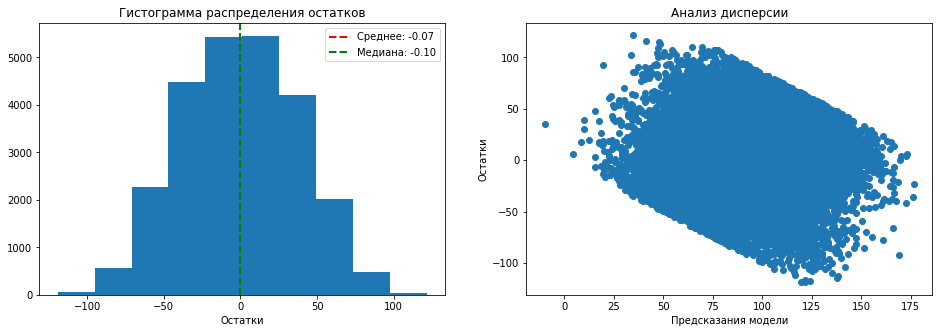

In [24]:
residuals(y_valid, predictions)

In [25]:
metrics(y_valid, predictions)

RMSE = 37.76
Средний запас предсказанного сырья = 92.4


In [26]:
data_0 = {
    'predictions': predictions,
    'y_valid': y_valid
}

geo_data_0_pred = pd.DataFrame(data_0)

Обучение и проверка модели для данных региона из датасета geo_data_1.

In [27]:
# получаем тренировочные и валидационные данные
X_train, X_valid, y_train, y_valid = separation_features(geo_data_1, target)

In [28]:
predictions = machine_learning_model(X_train, y_train, X_valid)

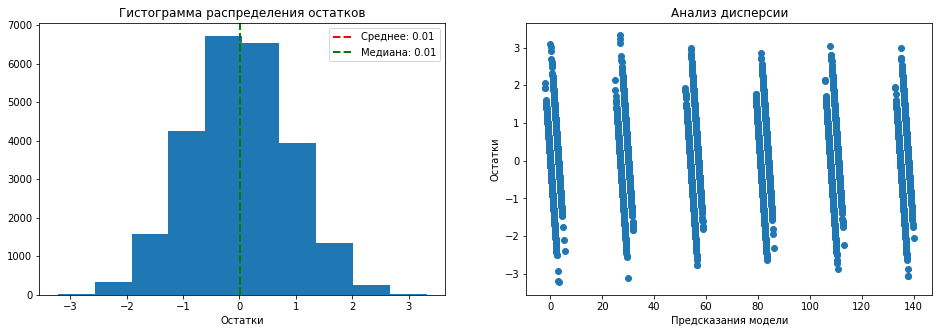

In [29]:
residuals(y_valid, predictions)

In [30]:
metrics(y_valid, predictions)

RMSE = 0.89
Средний запас предсказанного сырья = 68.71


In [31]:
data_1 = {
    'predictions': predictions,
    'y_valid': y_valid
}

geo_data_1_pred = pd.DataFrame(data_1)

Обучение и проверка модели для данных региона из датасета geo_data_2.

In [32]:
# получаем тренировочные и валидационные данные
X_train, X_valid, y_train, y_valid = separation_features(geo_data_2, target)

In [33]:
predictions = machine_learning_model(X_train, y_train, X_valid)

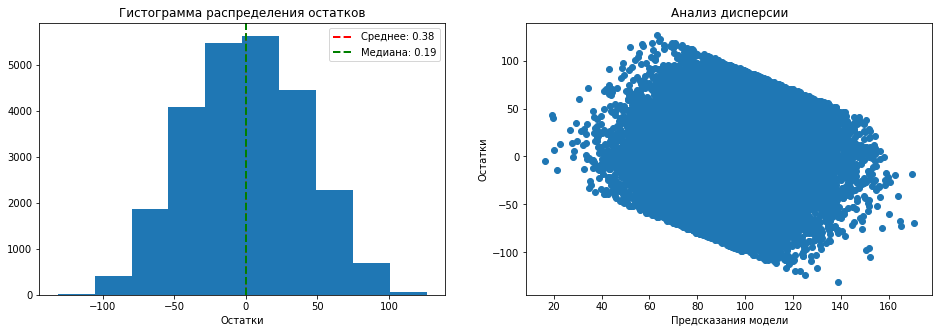

In [34]:
residuals(y_valid, predictions)

In [35]:
metrics(y_valid, predictions)

RMSE = 40.15
Средний запас предсказанного сырья = 94.77


In [36]:
data_2 = {
    'predictions': predictions,
    'y_valid': y_valid
}

geo_data_2_pred = pd.DataFrame(data_2)

**Вывод:** были обучены 3 модели для каждого региона и предсказан объём запасов в скважине.

| Датасет региона | RMSE | Средний запас предсказанного сырья | Средний запас сырья в регионе (по предоставленным данным) |
| :- | :-: | :-: | :-: |
| geo_data_0 | 37.76 | 92.4 | 92.5
| geo_data_1 | 0.89 | 68.71 | 68.83
| geo_data_2 | 40.15 | 94.77 | 95

Таким образом, самые лучшие результаты обучения на датасете geo_data_1, среднеквадратичная ошибка на валидационной выборке равна 0.89. Предсказания на датасетах geo_data_0 и geo_data_2 имеют среднеквадратичные ошибки 37.76 и 40.15 соответсвенно.

## Подготовка к расчёту прибыли 
<a class="anchor" id="chapter3"></a>

In [37]:
BUDGET = 10**10
PRODUCT_UNIT = 450 * 10**3
PROBABILITY_LOSSES = 0.025
N_BEST = 200
N_ALL = 500

In [38]:
break_even_volume = BUDGET/PRODUCT_UNIT/N_BEST
print(f'Безубыточный объём сырья {break_even_volume}')

Безубыточный объём сырья 111.11111111111111


**Вывод:** таким образом, безубыточный объём сырья для каждой скважины должен быть равен 111, что больше, чем средний запас сырья в каждом из регионов.

## Расчёт прибыли и рисков 
<a class="anchor" id="chapter4"></a>

In [39]:
def profit_calculation(target, pred, product_unit, budget, count):
    # выбираем 200 скважин с максимальными значениями предсказаний
    probs_sorted = pred.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    profit = product_unit * selected.sum()
    return profit - budget

In [40]:
def bootstrap(target, pred, product_unit, budget, n_best, n_all):
    values = []
    for i in range(1000):
        # извлекаем из выборки n случайных точек
        target_subsample = target.sample(n=n_all, replace=True, random_state=state)
        probs_subsample = pred[target_subsample.index]
 
        values.append(profit_calculation(target_subsample, probs_subsample, product_unit, budget, n_best))
    
    values = pd.Series(values)
    mean = values.mean()
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    risk_of_loss = sum(1 for v in values if v < 0) / len(values)

    print("Средняя прибыль:", mean)
    print('95% доверительный интервал:', lower, upper)
    print(f"Риск убытков: {risk_of_loss * 100:.2f}%")

In [41]:
profit_0 = profit_calculation(geo_data_0_pred['y_valid'], geo_data_0_pred['predictions'], PRODUCT_UNIT, BUDGET, N_BEST)
print(profit_0)

3359141114.462179


In [42]:
profit_1 = profit_calculation(geo_data_1_pred['y_valid'], geo_data_1_pred['predictions'], PRODUCT_UNIT, BUDGET, N_BEST)
print(profit_1)

2415086696.681511


In [43]:
profit_2 = profit_calculation(geo_data_2_pred['y_valid'], geo_data_2_pred['predictions'], PRODUCT_UNIT, BUDGET, N_BEST)
print(profit_2)

2598571759.374111


In [44]:
state = np.random.RandomState(12345)

In [45]:
bootstrap(geo_data_0_pred['y_valid'], geo_data_0_pred['predictions'], PRODUCT_UNIT, BUDGET, N_BEST, N_ALL)

Средняя прибыль: 435933772.1386621
95% доверительный интервал: -116231612.77720818 966504180.707376
Риск убытков: 6.10%


In [46]:
bootstrap(geo_data_1_pred['y_valid'], geo_data_1_pred['predictions'], PRODUCT_UNIT, BUDGET, N_BEST, N_ALL)

Средняя прибыль: 498569016.91678834
95% доверительный интервал: 75315573.08898354 911503695.0245577
Риск убытков: 1.00%


In [47]:
bootstrap(geo_data_2_pred['y_valid'], geo_data_2_pred['predictions'], PRODUCT_UNIT, BUDGET, N_BEST, N_ALL)

Средняя прибыль: 412672898.98853195
95% доверительный интервал: -158939515.7636048 978191201.7001915
Риск убытков: 7.00%


**Вывод:** 
- самая большая прибль по предсказанным данным в первом регионе и она составляет 3.359 млрд, во 2 и 3 регионах меньше (2.415 и 2.598 млрд);
- самая большая средняя прибыль во 2 региона, она составляет 498 млн;
- в 95% доверительный интервал 2 региона не входит отрицательная прибыль, в отличие от остальных двух регионов;
- самый маленький риск убытков также у 2 региона, он составляет 1%, риск убытков в 1 регионе равен 6.1%, а в 3 регионе 7%.

## Итоговый вывод 
<a class="anchor" id="chapter5"></a>

- была проведена загрузка и подготовка данных;
- были обучены 3 модели для каждого региона и предсказан объём запасов в скважине;
- был вычислен безубыточный объём сырья для каждой скважины равный 111;
- для каждого региона были вычислены следующие показатели: прибыль по предсказанным данным, средняя прибль, 95% доверительный интервал, риск убытков;

**Выбор региона для разработки скважин**

Для разработки скважин стоит взять 2 регион, так как он имеет самую высокую среднюю прибыль, в 95% доверительном интервале отсутствует отрицательная прибыль, процент риска убытков самый маленький и равен 1%, что удовлетваряет границе указаной в задаче 2.5%, в отличие от остальных 2 регионов. Судя по расчётам самую большую прибыль мы можем получить в 1 регионе, но риск убытков привышает порог больше, чем в 2 раза. Поэтому выбор 2 региона для разработки является оптимальным решением.

## Чек-лист готовности проекта 
<a class="anchor" id="chapter6"></a>

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован